<a href="https://colab.research.google.com/github/arbarvar/Colab_python_test/blob/main/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# predict stock by TensorFlow
#!pip install tensorflow pandas numpy matplotlib yahoo_fin sklearn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [4]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [8]:
#As a first step, we need to write a function that downloads the dataset from the Internet and preprocess it:

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                               test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [7]:
#Now that we have a proper function to load and prepare the dataset, we need another core function to build our model:

def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [9]:
#Now that we have all the core functions ready, let's train our model, but before we do that, let's initialize all our parameters (so you can edit them later on your needs):

# Window size or the sequence length
N_STEPS = 70
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Tesla stock market
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

So the above code is all about defining all the hyper parameters we gonna use, we explained some of them, while we didn't on the others:

    TEST_SIZE: The testing sample rate. For instance 0.2 means 20% of the total dataset.
    FEATURE_COLUMNS: The features we gonna use to predict the next price value.
    N_LAYERS: Number of RNN layers to use.
    CELL: RNN cell to use, default is LSTM.
    UNITS: Number of cell units.
    DROPOUT: The dropout rate is the probability of not training a given node in a layer, where 0.0 means no dropout at all. This type of regularization can help the model to not overfit on our training data.
    BIDIRECTIONAL: Whether to use bidirectional recurrent neural networks.
    LOSS: Loss function to use for this regression problem, we're using Huber loss, you can use mean absolute error (mae) or mean squared error (mse) as well.
    OPTIMIZER: Optimization algorithm to use, defaulting to Adam.
    BATCH_SIZE: The number of data samples to use on each training iteration.
    EPOCHS: The number of times that the learning algorithm will pass through the entire training dataset, we used 400 here, but try to increase it further more.

Feel free to experiment with these values to get better results than mine.

In [10]:
# let's make sure the results, logs and data folders exist before we train:

# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [11]:
#Finally, let's train the model:

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/400
 1/32 [..............................] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.1072WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
32/32 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0422
Epoch 00001: val_loss improved from inf to 0.00077, saving model to results/2020-11-14_TSLA-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
32/32 [==============================] - 5s 146ms/step - loss: 0.0027 - mean_absolute_error: 0.0422 - val_loss: 7.6556e-04 - val_mean_absolute_error: 0.0260
Epoch 2/400
32/32 [==============================] - ETA: 0s - loss: 9.6935e-04 - mean_absolute_error: 0.0250
Epoch 00002: val_loss did not improve from 0.00077
32/32 [==============================] - 3s 109ms/step -

In [ ]:
#After the training ends (or during the training), try to run tensorboard using this command:

tensorboard --logdir="logs"

#Now this will start a local HTTP server "localhost:6006", after going to the browser

In [13]:
#Before we test our model, we gonna need to reload the data with no shuffling, as we are going to plot the stock price curve in the correct order:

data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [14]:
#let's test our model:

# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

#Remember that the output will be a value between 0 to 1, so we need to get it back to a real price value, here is the output:

#Mean Absolute Error: 6.516846878481972

Mean Absolute Error: 7.392075314137853


In [15]:
# let's try to predict the future price of Apple Stock Market:

def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [16]:
#This function uses the last_sequence variable we saved in the load_data() function, which is basically the last sequence of prices, we use it to predict the next price, let's call this:

# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
#Output:
#Future price after 1 days is 404.78$

#Sounds interesting ! Two days before, the price was 447.37$, and yesterday was 416.43$, the model is saying that the next day, it will be 404.78$.
#A trending decrease. The model just used 70 days of features to be able to get that value, 

Future price after 1 days is 414.98$


In [18]:
 #let's plot the prices and see:

def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

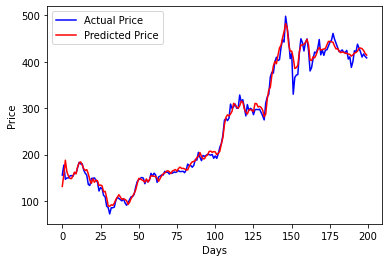

In [19]:
#This function plots the last 200 days of the test set (you can edit it as you wish) as well as the predicted prices, let's call it and see how it looks like:

plot_graph(model, data)

Great, as you can see, the blue curve is the actual test set, and the red curve is the predicted prices ! Notice that the stock price recently is decreasing, as we predicted.

This will still work if you have higher LOOKUP_STEP, but it will use older data (older by LOOKUP_STEP days) in order to draw the red line.

Until now, we have used to predict only the next day, I have tried to build other models that use different lookup_steps, here is an interesting result in tensorboard:
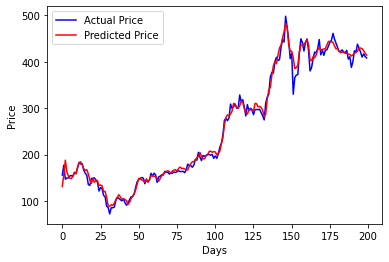
Interestingly enough, the blue curve is the model we used in the tutorial, which uses the next timestep stock price as the label, whereas the green and orange curves used 10 and 30 lookup steps respectively, for instance, in this example, the orange model predicts the stock price after 30 days, which is a great model for more long term investments (which is usually the case).

Now you may think that, but what if we just want to predict if the price is going to rise or fall, not the actual price value as we did here, well you can do it using one of the two ways, one is you compare the predicted price with the current price and you make the decision, or you build an entire model and change the last output's activation function to sigmoid, as well as the loss and the metrics.

In [20]:
#The below function calculates the accuracy score by converting the predicted price to 0 or 1 (0 indicates that the price went down, and 1 indicates that it went up):

def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

#Now let's call the function:

print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))



1: Accuracy Score: 0.5846456692913385


As you may notice, the model predicts more accurately in long term prices, it reaches about 71.9% when we train the model to predict the price of the next 10 days, and it reaches about 83.2% accuracy when using 30 lookup steps.